# Softened Isothermal Ellipsoid

In the following piece of code, the properties of the NIE are derived using the module deflector. First, we compute the convergence map of a NIE model for given values of $f$ and $x_c$. Then, we use the module deflector to compute the potential. From the potential, we will derive all the lens properties.

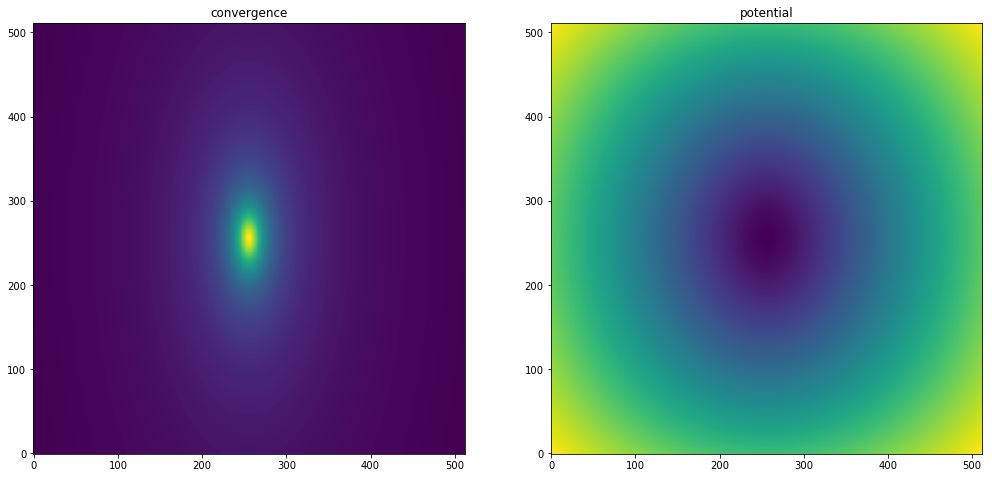

In [1]:
import deflector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline

def kappa_nie(xk,yk,f,xc):    
    x1,x2=np.meshgrid(xk,yk)
    mappa=np.sqrt(f)/2.0/np.sqrt(x1**2+f**2*x2**2+xc**2)
    return(mappa)

f=0.45
xc=0.2
npix=512
x1=np.linspace(-5.0,5.0,npix)
x2=np.linspace(-5.0,5.0,npix)
kappa=kappa_nie(x1,x2,f,xc)

from astropy.io import fits
hdu = fits.PrimaryHDU(kappa)
cdelt=(np.max(x1)-np.min(x1))/(x1.size-1)
hdu.header['CDELT1']=cdelt
hdu.header['CDELT2']=cdelt
hdulist = fits.HDUList([hdu])
hdulist.writeto('kappa_nie.fits',clobber=True)

df=deflector.deflector('kappa_nie.fits',True)
kappa=df.kmap()
pot=df.potential()
kappa=df.mapCrop(kappa)
pot=df.mapCrop(pot)

fig,ax = plt.subplots(1,2,figsize=(17,8))
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(pot,origin="lower")
ax[1].set_title('potential')

Now that we have the lensing potential, we can compute the deflection angles:

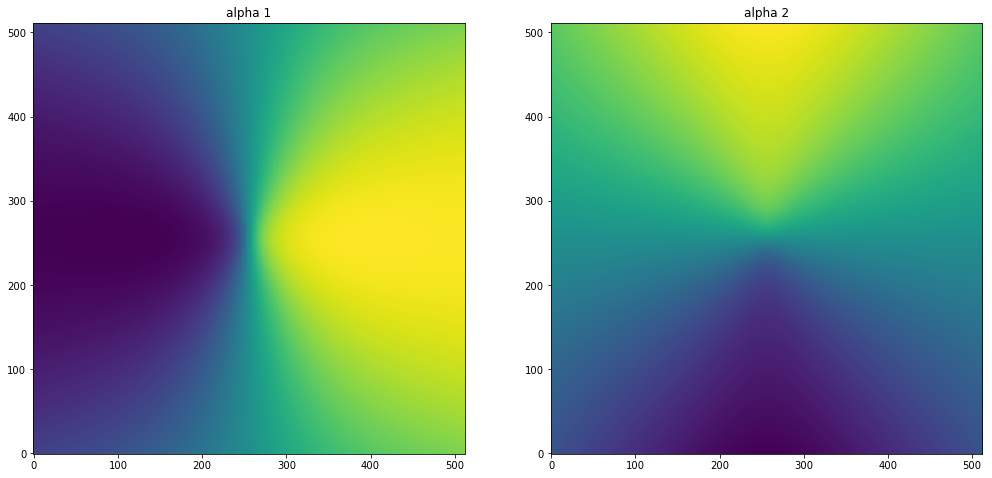

In [2]:
import numpy as np
a1,a2=df.angle_map()
fig,ax = plt.subplots(1,2,figsize=(17,8))
ax[0].imshow(a1,origin="lower")
ax[0].set_title('alpha 1')
ax[1].imshow(a2,origin="lower")
ax[1].set_title('alpha 2')

Finally, we compute the eigenvalues of the lensing Jacobian. The critical lines and caustics are the curves of level 0 in the maps of the eigenvalues and of $\det A$.

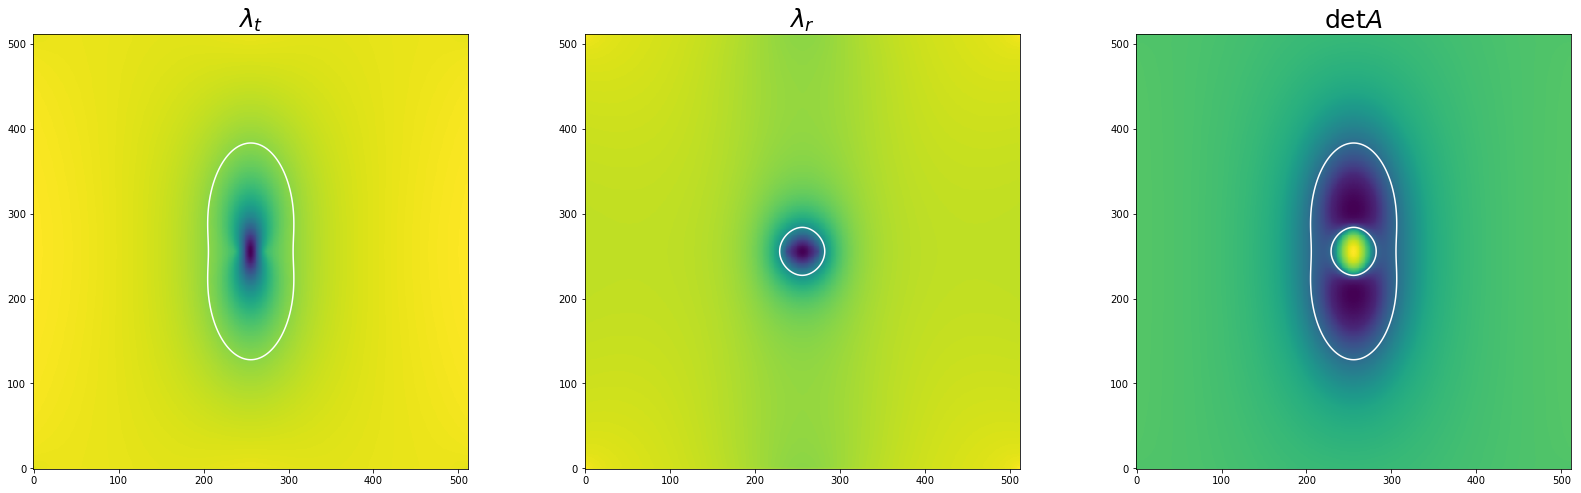

In [3]:
gamma_1,gamma_2=df.shear_map()

gamma=np.sqrt(gamma_1**2+gamma_2**2)
detA=(1.0-kappa-gamma)*(1.0-kappa+gamma)
lambdat=1.0-kappa-gamma
lambdar=1.0-kappa+gamma

fig,ax=plt.subplots(1,3,figsize=(28,8))
ax[0].imshow(lambdat,origin='lower')
ax[0].contour(lambdat,levels=[0.0],colors=['white'])
ax[0].set_title('$\lambda_t$',fontsize=25)
ax[1].imshow(lambdar,origin='lower')
ax[1].contour(lambdar,levels=[0.0],colors=['white'])
ax[1].set_title('$\lambda_r$',fontsize=25)
ax[2].imshow(detA,origin='lower',norm=SymLogNorm(0.3))
ax[2].contour(detA,levels=[0.0],colors=['white'])
ax[2].set_title('$\det A$',fontsize=25)

The zero-level contours can be extracted from the image. These are polygons whose vertices can be extracted and saved as critical points. Once this is done, they can be mappend onto the source plane to find the corresponding caustic points.

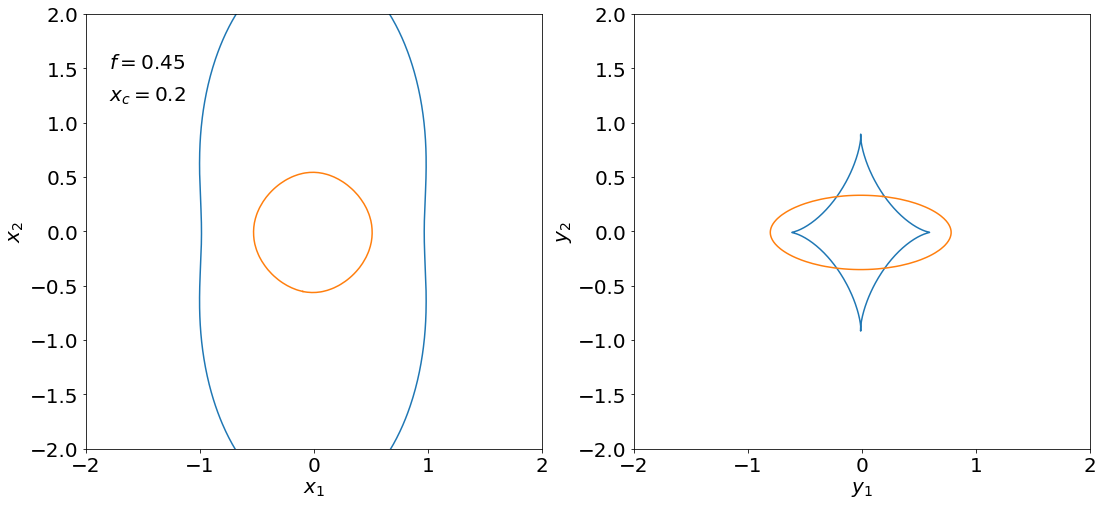

In [4]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
cs=ax[0].contour(detA,levels=[0.0])

contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

from scipy.ndimage import map_coordinates

if (sizevs.size > 0):
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
            xx1,xx2=vs[i]
            x1.append(float(xx1))
            x2.append(float(xx2))
        # thse are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
        a_1=map_coordinates(a1, [[x2],[x1]],order=1)
        a_2=map_coordinates(a2, [[x2],[x1]],order=1)
        
        # now we can make the mapping using the lens equation:
        y1=x1-a_1[0]
        y2=x2-a_2[0]
        
        # plot the results!
        xx1=(np.array(x1)-npix/2.0)*cdelt
        xx2=(np.array(x2)-npix/2.0)*cdelt
        yy1=(np.array(y1)-npix/2.0)*cdelt
        yy2=(np.array(y2)-npix/2.0)*cdelt
        ax[0].plot(xx1,xx2,'-')
        ax[1].plot(yy1,yy2,'-')
        
ax[1].set_xlim([-2,2])
ax[1].set_ylim([-2,2])
ax[0].set_xlim([-2,2])
ax[0].set_ylim([-2,2])
                      
ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)
ax[1].set_xlabel('$y_1$',fontsize=20)
ax[1].set_ylabel('$y_2$',fontsize=20)
for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=20)
    ax[i].yaxis.set_tick_params(labelsize=20)

ax[0].text(-1.8,1.5,'$f=$'+str(f),fontsize=20)
ax[0].text(-1.8,1.2,'$x_c=$'+str(xc),fontsize=20)
fig.savefig('nie_critcaust_25.png')

The figure below show the transitions between the possible caustic configurations.

In particular:
* if $x_c<f^{3/2}/2$ there are two distinguished critical lines and caustics. One caustic is the tangential caustic and has four cusps. The other is the radial one and it has not cusps. The tangential caustic is completely contained within the radial caustic if the ellipticity is small ($f$ is large). Even in the case of mildly elliptical lenses, the radial caustic contains the tangential caustic if the core is small enough;
* if $f^{3/2}/2<xc<f^{3/2}/(1+f)$, the radial caustic is contained within the tangential caustic. In addition both the radial and the tangential caustics have only two cusps;
* if $f^{3/2}/(1+f)<xc<f^{1/2}/(1+f)$, the lens has only a tangential critical line and caustic. The radial critical lines and caustics disappear for $xc=f^{3/2}/(1+f)$;
* even the tangential caustic disappears if $xc=f^{1/2}/(1+f)$. Thus, for $xc>f^{1/2}/(1+f)$ the lens does not have critical lines and caustics.

(0.0, 0.5)

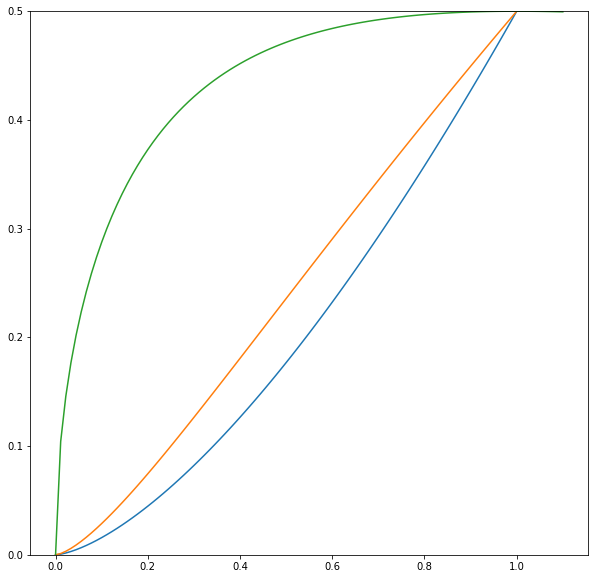

In [5]:
f_vec=np.linspace(0,1.1,100)
xc1=f_vec**1.5/2.0
xc2=f_vec**1.5/(1.0+f_vec)
xc3=f_vec**0.5/(1.0+f_vec)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.plot(f_vec,xc1,'-')#
ax.plot(f_vec,xc2,'-')
ax.plot(f_vec,xc3,'-')

ax.set_ylim([0.0,0.5])

# Pseudo Elliptical Lenses

Pseudo-elliptical lenses are generally referred as lenses generated by ellipticizing the lensing potential rather than the surface density distribution.
In other words:

$$
\psi(\vec x)=\psi(\sqrt{x_1^2+f^2x_2^2})
$$

The great advantage of dealing with the potential is that all lens properties can be derived more easily by means of its derivatives (see the deflector module). 

We may try to build an elliptical softened isothermal sphere as follows:
$$
\psi(\vec x)=\sqrt{x_1^2+f^2x_2^2+x_c^2}
$$

Here are some lines of code to derive the properties of the pseudo-NIE model.

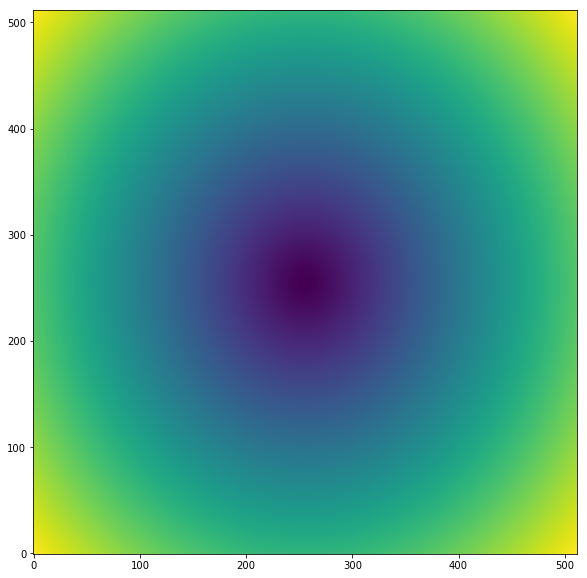

In [6]:
# step 1: build a potential map

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def psi_nie(xk,yk,f,xc):
    x1,x2=np.meshgrid(xk,yk)
    mappa=np.sqrt(x1**2+f**2*x2**2+xc**2)
    return(np.abs(mappa))

f=0.9 # try also: 0.6, 0.4
xc=0.2
xmin=-3
xmax=3
ymin=-3
ymax=3
npix=512

xk=np.linspace(xmin,xmax,npix)
yk=np.linspace(ymin,ymax,npix)

psi=psi_nie(xk,yk,f,xc)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(psi,origin='low')

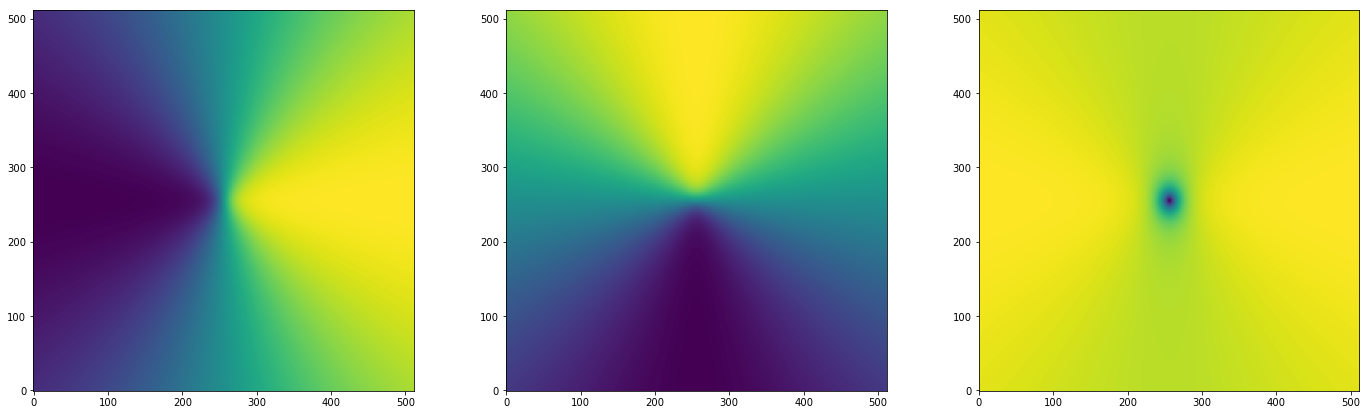

In [7]:
# step 2: from the potential to the deflection angle

dx=float(xmax-xmin)/(npix-1)
alpha2,alpha1=np.gradient(psi,dx,dx)
fig,ax=plt.subplots(1,3,figsize=(24,7))
ax[0].imshow(alpha1,origin='low')
ax[1].imshow(alpha2,origin='low')
ax[2].imshow(np.sqrt(alpha1*alpha1+alpha2*alpha2),origin='low')

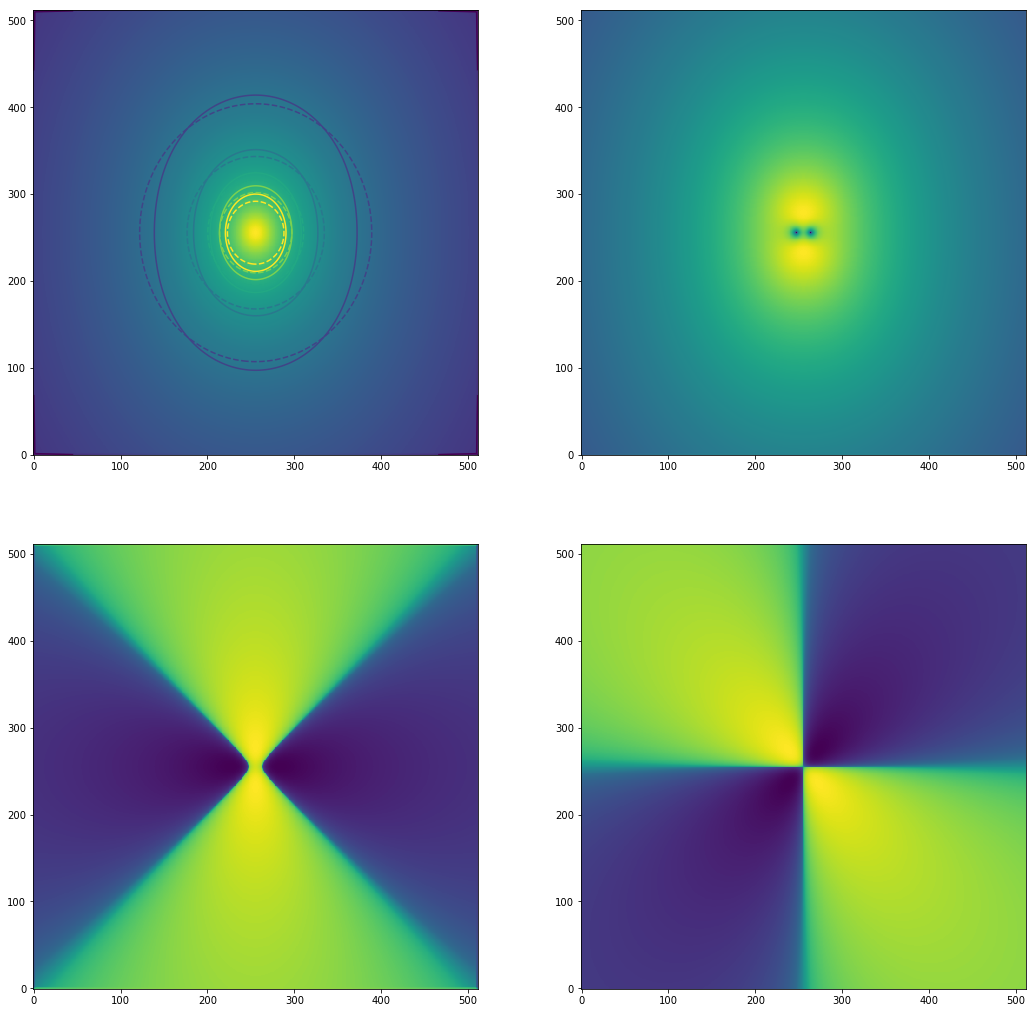

In [8]:
from matplotlib.colors import LogNorm, SymLogNorm

da1dx2,da1dx1=np.gradient(alpha1,dx,dx)
da2dx2,da2dx1=np.gradient(alpha2,dx,dx)

kappa=0.5*(da1dx1+da2dx2)
gamma1=0.5*(da1dx1-da2dx2)
gamma2=da1dx2


gamma=np.sqrt(gamma1*gamma1+gamma2*gamma2)

fig,ax=plt.subplots(2,2,figsize=(18,18))
ax[0,0].imshow(kappa,origin='low',norm=LogNorm())
cs=ax[0,0].contour(kappa,levels=[0.1,0.3,0.5,0.7,0.9,1.1])
ax[0,1].imshow(gamma,origin='low',norm=LogNorm())
ax[1,0].imshow(gamma1,origin='low',norm=SymLogNorm(linthresh=0.01))
ax[1,1].imshow(gamma2,origin='low',norm=SymLogNorm(linthresh=0.01))


########## compare to the NIE

kappa_nie=kappa_nie(xk,yk,f,xc)
cs=ax[0,0].contour(kappa_nie,linestyles='dashed',levels=[0.1,0.3,0.5,0.7,0.9,1.1])

The upper left panel shows the convergence map of the pseudo elliptical lens, with overlaid some contours (solid lines). The dashed contours are the iso-convergence contours for the corresponding elliptical lens (the NIE studied in the past lesson). Note that 
* the NIE contours are rounder
* the NIE$_\psi$ contours are not elliptical!
* try out by increasing the ellipticity of the model (reduce $f$)...

Let see the critical lines:

(0, 512)

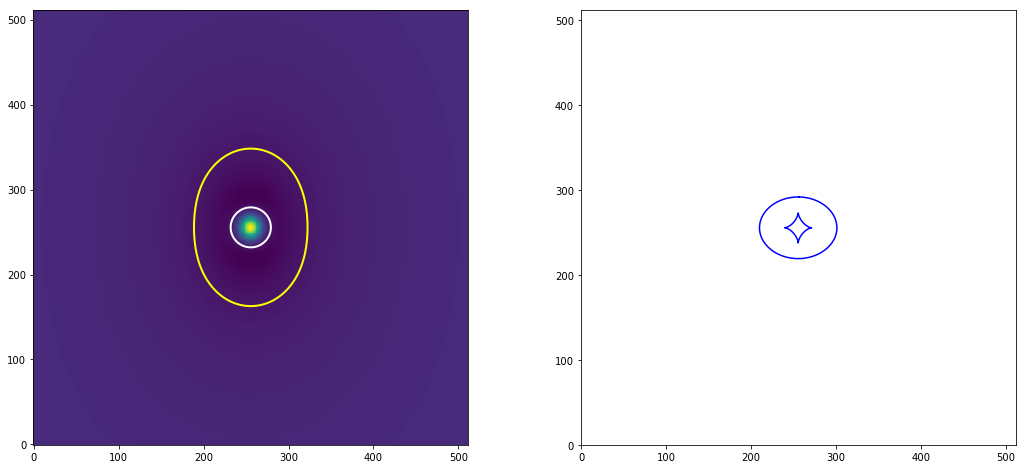

In [9]:
lambdat=1-kappa-gamma
lambdar=1-kappa+gamma
                   
            
fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[0].imshow((lambdat*lambdar),origin='low')
cst=ax[0].contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
ax[1].imshow(lambdar,origin='low',alpha=0)
csr=ax[0].contour(lambdar,levels=[0.0],colors='white',linewidths=2)

# caustics!
cs=ax[0].contour((lambdat*lambdar),levels=[0.0],alpha=0)
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

from scipy.ndimage import map_coordinates

if (sizevs.size > 0):
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
            xx1,xx2=vs[i]
            x1.append(float(xx1))
            x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
        a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
        a2=map_coordinates(alpha2, [[x2],[x1]],order=1)
        
        # now we can make the mapping using the lens equation:
        y1=x1-a1[0]/(float(xmax-xmin)/npix)
        y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
        ax[1].plot(y1,y2,'-',color='blue')
        
ax[1].set_xlim([0,npix])
ax[1].set_ylim([0,npix])

# External perturbations

The following example shows how the addition of an external perturbation modifies the properties of a  NIS model. The external shear is added by summing the potential

$$
\Psi_\gamma=\frac{1}{2}\gamma_1(x_1^2-x_2^2)+\gamma_2x_1x_2
$$

to the potential of the NIS.

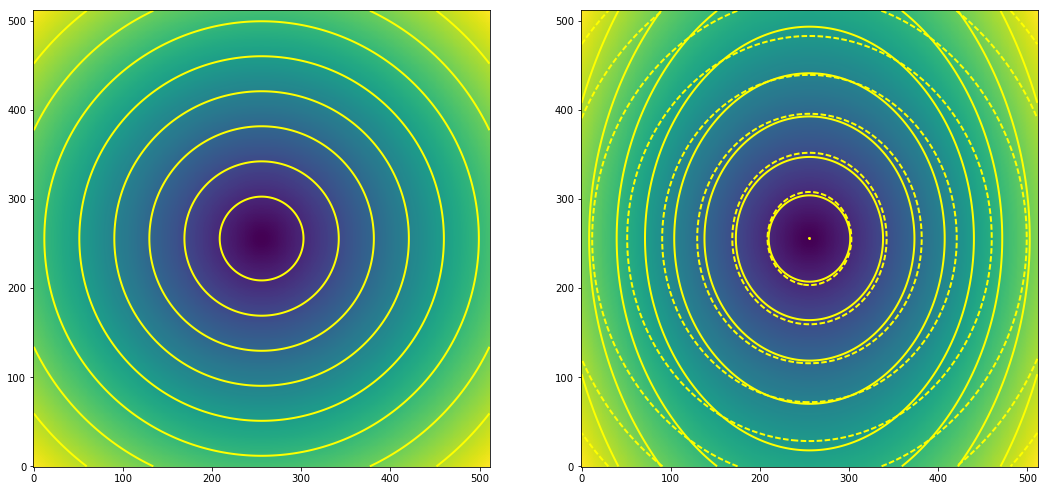

In [10]:
def psi_extg(xk,yk,g1,g2):
    x1_,x2_=np.meshgrid(xk,yk) # lens plane mesh
    psi_g=g1/2.0*(x1_**2-x2_**2)+g2*x1_*x2_
    return(psi_g)

def kappa_ell_map(xk,yk,f,xc):
    x1_,x2_=np.meshgrid(xk,yk)
    return(np.sqrt(f)/2.0/np.sqrt(x1_**2+f**2*x2_**2+xc**2))

f=1.0 
xc=0.1
xmin=-3
xmax=3
ymin=-3
ymax=3
npix=512
'''
the angle phi_g defines the direction of the shear
'''
phi_g=90.0
'''
g is the amplitude of the shear
'''
g=0.1
'''
g1, g2 are the two components of g
'''
g1=-g*np.cos(2.0*phi_g*np.pi/180.0)
g2=-g*np.sin(2.0*phi_g*np.pi/180.0)

xk=np.linspace(xmin,xmax,npix)
yk=np.linspace(ymin,ymax,npix)

psi=psi_nie(xk,yk,f,xc)
psi_ext=psi_extg(xk,yk,g1,g2)

'''
Let's compare to the potentia of a NIE model
'''
psi_comp=psi_nie(xk,yk,0.9,xc)

fig,ax=plt.subplots(1,2,figsize=(18,10))
ax[0].imshow(psi,origin='low')
levels=np.linspace(np.min(psi),np.max(psi),10)
cst=ax[0].contour(psi,levels=levels,colors='yellow',linewidths=2)
ax[1].imshow(psi+psi_ext,origin='low')
#levels=np.linspace(np.min(psi),np.max(psi),10)
cst=ax[1].contour(psi+psi_ext,levels=levels,colors='yellow',linewidths=2)
cst=ax[1].contour(psi_comp,linestyles='dashed',levels=levels,colors='yellow',linewidths=2)

It is interesting to note that the external shear makes the iso-potential lines elliptical (see solid lines). The dashed lines are the equivalent iso-potential curves for a NIE. The ellipticity has been chosen to approximately match  the shape of the solid contours.

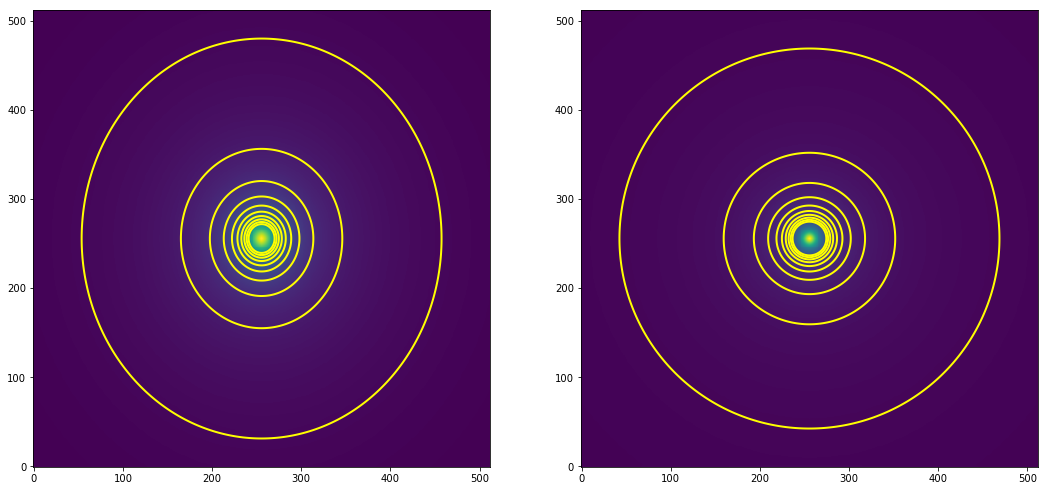

In [11]:
dx=float(xmax-xmin)/(npix-1)
alpha2,alpha1=np.gradient(psi+psi_ext,dx,dx)
da1dx2,da1dx1=np.gradient(alpha1,dx,dx)
da2dx2,da2dx1=np.gradient(alpha2,dx,dx)

kappa=0.5*(da1dx1+da2dx2)
kappa_ell=kappa_ell_map(xk,yk,0.9,xc)
gamma1=0.5*(da1dx1-da2dx2)
gamma2=da1dx2


gamma=np.sqrt(gamma1*gamma1+gamma2*gamma2)

fig,ax=plt.subplots(1,2,figsize=(18,10))
ax[1].imshow(kappa,origin='low')
levels=np.linspace(0.2,2.4,10)
cst=ax[1].contour(kappa,levels=levels,colors='yellow',linewidths=2)
ax[0].imshow(kappa_ell,origin='low')
#levels=np.linspace(np.min(psi),np.max(psi),10)
cst=ax[0].contour(kappa_ell,levels=levels,colors='yellow',linewidths=2)

The contours of the convergence maps show that, by construction, the external shear does not contribute to the convergence, which remains axially symmetric (right panel).

(0, 512)

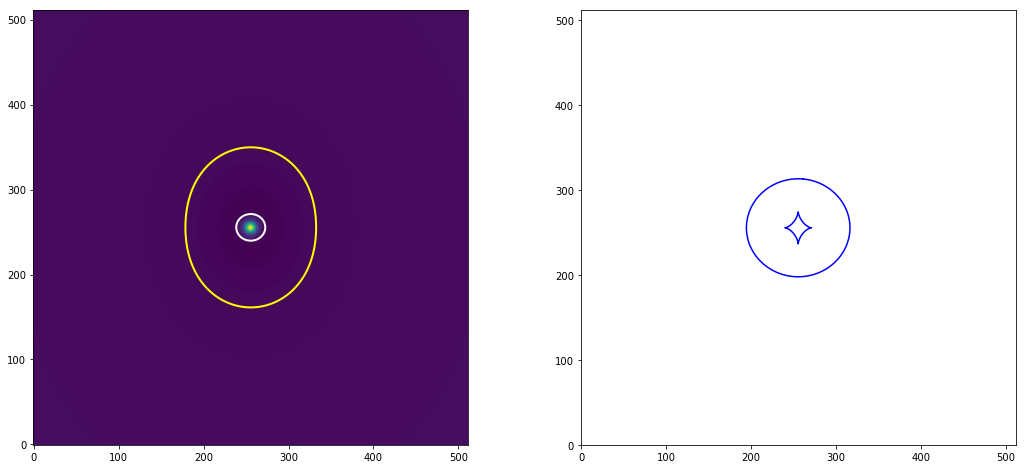

In [12]:
lambdat=1-kappa-gamma
lambdar=1-kappa+gamma
                   
            
fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[0].imshow((lambdat*lambdar),origin='low')
cst=ax[0].contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
ax[1].imshow(lambdar,origin='low',alpha=0)
csr=ax[0].contour(lambdar,levels=[0.0],colors='white',linewidths=2)

# caustics!
cs=ax[0].contour((lambdat*lambdar),levels=[0.0],alpha=0)
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

from scipy.ndimage import map_coordinates

if (sizevs.size > 0):
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
            xx1,xx2=vs[i]
            x1.append(float(xx1))
            x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
        a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
        a2=map_coordinates(alpha2, [[x2],[x1]],order=1)
        
        # now we can make the mapping using the lens equation:
        y1=x1-a1[0]/(float(xmax-xmin)/npix)
        y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
        ax[1].plot(y1,y2,'-',color='blue')
        
ax[1].set_xlim([0,npix])
ax[1].set_ylim([0,npix])

However, the critical lines and caustics are similar to those of an elliptical lens!

# Substructures

Lenses generally contain substructures. How can we model them. The method is simple: substructures are lenses within other lenses. Given their small scale, however their effect is local. In particular, in case of multiple images appearing at large distances from each other, one substructure may affect only one of the images (i.e. the image probing the line-of-sight which has a small impact parameter with the substructure.

The inclusion of substructure into an extended lens model consists of summing up the potential or the deflection fields of the substructures themselves with that of the main lens.

Here is an example. We generate a number of substructures to be randomly distributed on the top of a NIE model. These substructures are scaled-down versions of the lens within which they are distributed.

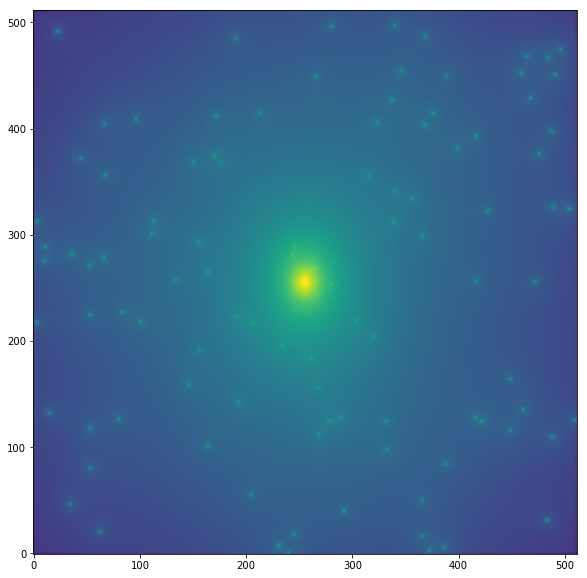

In [13]:
def pot_ell_nie(xk,yk,f,xc,x0,y0,xfact):

    
    x1,x2=np.meshgrid(xk,yk) # lens plane mesh
    psi=np.sqrt((x1-x0)**2+f**2*(x2-y0)**2+xc**2)/xfact

    return(psi)

'''
This is the main lens: a pseudo nie model with f=0.9, xc=0.1
'''
psi=pot_ell_nie(xk,yk,0.9,0.1,0.0,0.0,1.0)

'''
now, we generate a bunch of perturbers
'''
n_pert=100

xsub=(np.random.random_sample(n_pert)-0.5)*np.max(xk)*2.0
ysub=(np.random.random_sample(n_pert)-0.5)*np.max(xk)*2.0

'''
let's assume that all the substructures are scaled down by a factor 10 with respect to the main lens
and that they are all spherical
'''

for i in range(n_pert):
    psi_sub=pot_ell_nie(xk,yk,1.0,0.0,xsub[i],ysub[i],100.0)
    psi=psi+psi_sub
    
'''
now we can inspect the resulting mass distribution
'''
dx=float(xmax-xmin)/(npix-1)
alpha2,alpha1=np.gradient(psi,dx,dx)
da1dx2,da1dx1=np.gradient(alpha1,dx,dx)
da2dx2,da2dx1=np.gradient(alpha2,dx,dx)

kappa=0.5*(da1dx1+da2dx2)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(kappa,origin='low',norm=LogNorm())



And the critical lines and caustics...

(0, 512)

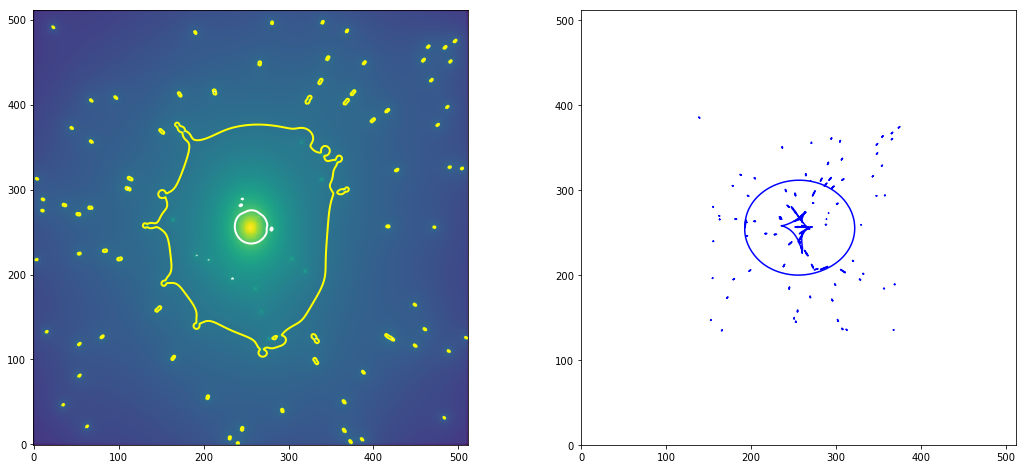

In [14]:
gamma1=0.5*(da1dx1-da2dx2)
gamma2=da1dx2


gamma=np.sqrt(gamma1*gamma1+gamma2*gamma2)

lambdat=1-kappa-gamma
lambdar=1-kappa+gamma
                   
            
fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[0].imshow(kappa,origin='low',norm=LogNorm())
cst=ax[0].contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
ax[1].imshow(lambdar,origin='low',alpha=0)
csr=ax[0].contour(lambdar,levels=[0.0],colors='white',linewidths=2)

# caustics!
cs=ax[0].contour((lambdat*lambdar),levels=[0.0],alpha=0)
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

from scipy.ndimage import map_coordinates

if (sizevs.size > 0):
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
            xx1,xx2=vs[i]
            x1.append(float(xx1))
            x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
        a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
        a2=map_coordinates(alpha2, [[x2],[x1]],order=1)
        
        # now we can make the mapping using the lens equation:
        y1=x1-a1[0]/(float(xmax-xmin)/npix)
        y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
        ax[1].plot(y1,y2,'-',color='blue')
        
ax[1].set_xlim([0,npix])
ax[1].set_ylim([0,npix])

# Ray-tracing and image reconstruction

Suppose we have a source in the background of our lens. We want to reconstruct its images. How to do that? 

One common technique consists of propagating light-rays from the observer position towards the source (ray-tracing). Then, the light-rays hitting the source are identified. The points where the rays were coming from do belong to the images. This allows to reconstruct the images.

Here is an example.

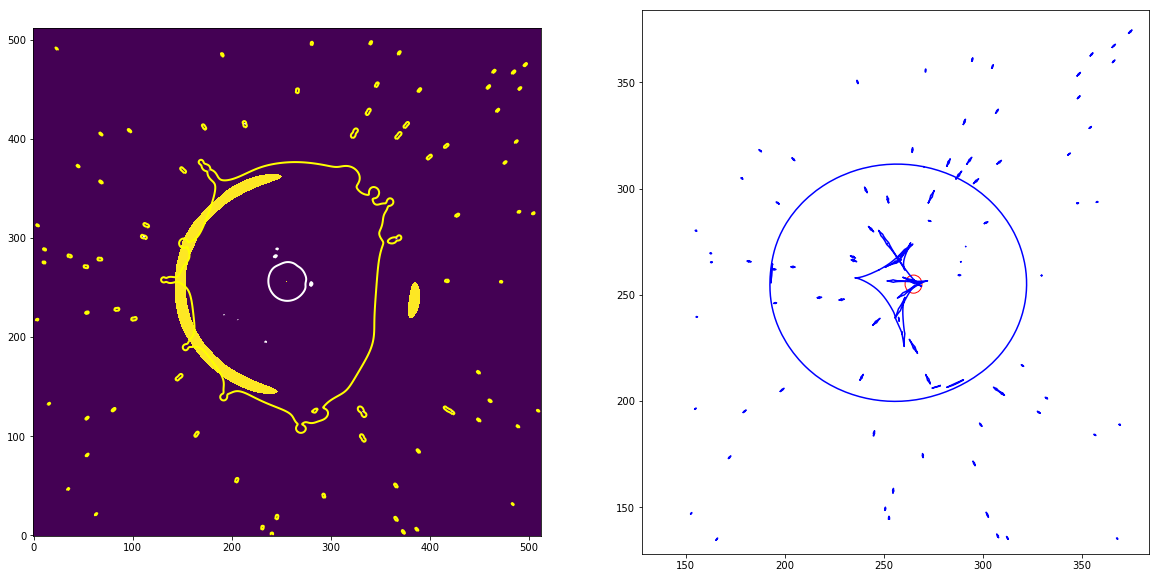

In [15]:
def ray_trace(xk,yk,alpha1,alpha2):

    
    x1_,x2_=np.meshgrid(xk,yk) # lens plane mesh
    y1=(xk-alpha1) # y1 coordinates on the source plane
    y2=np.transpose(yk-np.transpose(alpha2)) # y2 coordinates on the source plane

    #mappa=mappa.reshape([xk.size,yk.size],order='F')

    return(x1_,x2_,y1,y2)

def lens_source(y1,y2,ys1,ys2,r):
    d2=(y1-ys1)**2+(y2-ys2)**2
    image=np.zeros(y1.shape)
    image[d2<r**2]=1.0
    return(image)
    

x1,x2,y1,y2=ray_trace(xk,yk,alpha1,alpha2)

r=0.05

'''
some test cases:
- cusp arc: 255, 265
- fold arc: 260, 260
- cusp arc: 265, 255
- einstein cross: 255, 255
- radial arc: 297, 297

'''
ys1_pix=265
ys2_pix=255

ys1=(ys1_pix-npix/2.)*2.0*np.max(xk)/npix
ys2=(ys2_pix-npix/2.)*2.0*np.max(xk)/npix

rpix=r/2.0/np.max(xk)*npix

image=lens_source(y1,y2,ys1,ys2,r)


fig,ax=plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(image,origin='low')
cst=ax[0].contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
csr=ax[0].contour(lambdar,levels=[0.0],colors='white',linewidths=2)

# caustics!
cs=ax[0].contour((lambdat*lambdar),levels=[0.0],alpha=0)
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

from scipy.ndimage import map_coordinates

if (sizevs.size > 0):
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
            xx1,xx2=vs[i]
            x1.append(float(xx1))
            x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
        a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
        a2=map_coordinates(alpha2, [[x2],[x1]],order=1)
        
        # now we can make the mapping using the lens equation:
        y1=x1-a1[0]/(float(xmax-xmin)/npix)
        y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
        ax[1].plot(y1,y2,'-',color='blue')
        
ax[1].set_xlim([npix/4,3.*npix/4])
ax[1].set_ylim([npix/4,3.*npix/4])


circle_out=plt.Circle((ys1_pix,ys2_pix),rpix,color='red',fc='blue',fill=False)

ax[1].add_artist(circle_out)


# An even more interesting experiment...

What if the sources we want to lens are characterized by some surface brightness? We can generalize the simulation done before to include this feature. In this case, we read the brightness to be assigned to each point on the image plane from the position where the light rays hit the source.


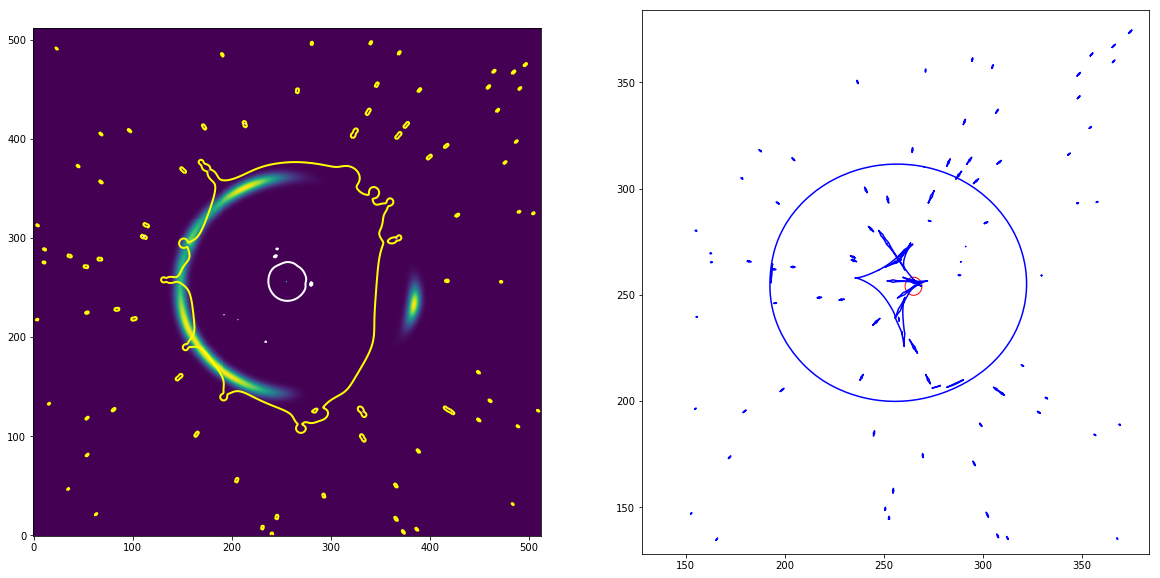

In [16]:
def lens_source_with_prof(y1,y2,ys1,ys2):
    rscale=0.05
    d2=((y1-ys1)**2+(y2-ys2)**2)
    image=np.exp(-d2/rscale**2)
    return(image)

x1,x2,y1,y2=ray_trace(xk,yk,alpha1,alpha2)

r=0.05

'''
some test cases:
- cusp arc: 255, 265
- fold arc: 260, 260
- cusp arc: 265, 255
- einstein cross: 255, 255
- radial arc: 297, 297

'''
ys1_pix=265
ys2_pix=254

ys1=(ys1_pix-npix/2.)*2.0*np.max(xk)/npix
ys2=(ys2_pix-npix/2.)*2.0*np.max(xk)/npix

rpix=r/2.0/np.max(xk)*npix

image=lens_source_with_prof(y1,y2,ys1,ys2)


fig,ax=plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(image,origin='low')
cst=ax[0].contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
csr=ax[0].contour(lambdar,levels=[0.0],colors='white',linewidths=2)

# caustics!
cs=ax[0].contour((lambdat*lambdar),levels=[0.0],alpha=0)
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

from scipy.ndimage import map_coordinates

if (sizevs.size > 0):
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
            xx1,xx2=vs[i]
            x1.append(float(xx1))
            x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
        a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
        a2=map_coordinates(alpha2, [[x2],[x1]],order=1)

        
        # now we can make the mapping using the lens equation:
        y1=x1-a1[0]/(float(xmax-xmin)/npix)
        y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
        ax[1].plot(y1,y2,'-',color='blue')
        
ax[1].set_xlim([npix/4,3.*npix/4])
ax[1].set_ylim([npix/4,3.*npix/4])


circle_out=plt.Circle((ys1_pix,ys2_pix),rpix,color='red',fc='blue',fill=False)

ax[1].add_artist(circle_out)

(512, 512)


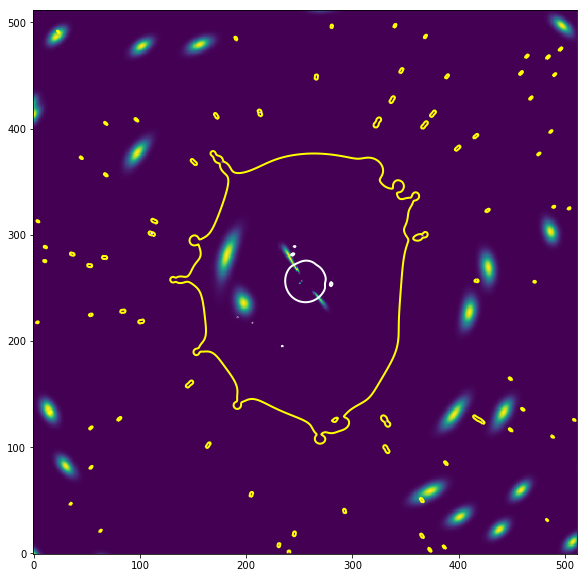

In [17]:
x1,x2,y1,y2=ray_trace(xk,yk,alpha1,alpha2)

'''
now, we generate a bunch of sources
'''
ngal=100
ys1=(np.random.random_sample(ngal)-0.5)*np.max(xk)*2.0
ys2=(np.random.random_sample(ngal)-0.5)*np.max(xk)*2.0

'''
we lens each of them
'''
print y1.shape
image0=np.zeros(y1.shape)
for i in range(ngal):
    image=lens_source_with_prof(y1,y2,ys1[i],ys2[i])
    image0=image0+image
    
fig,ax=plt.subplots(1,1,figsize=(10,10))

ax.imshow(image0,origin='low',vmax=1)
cst=ax.contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
csr=ax.contour(lambdar,levels=[0.0],colors='white',linewidths=2)

# Image finding via grid search

Images can be serached also by solving the lens equation numerically. This can be done as explained in the Schneider, Ehlers and Falco (1992). The method consists in dividing each cell in the image plane into two triangles. Each triangle, when mapped onto the source plane, remains a triangle, i.e. a convex figure. The solution of the lens equation can be found by searching the triangles on the source plane which contain the source. The approximated position of the images is then given by the location of the corresponding triangle on the image plane.

-3.0 3.0


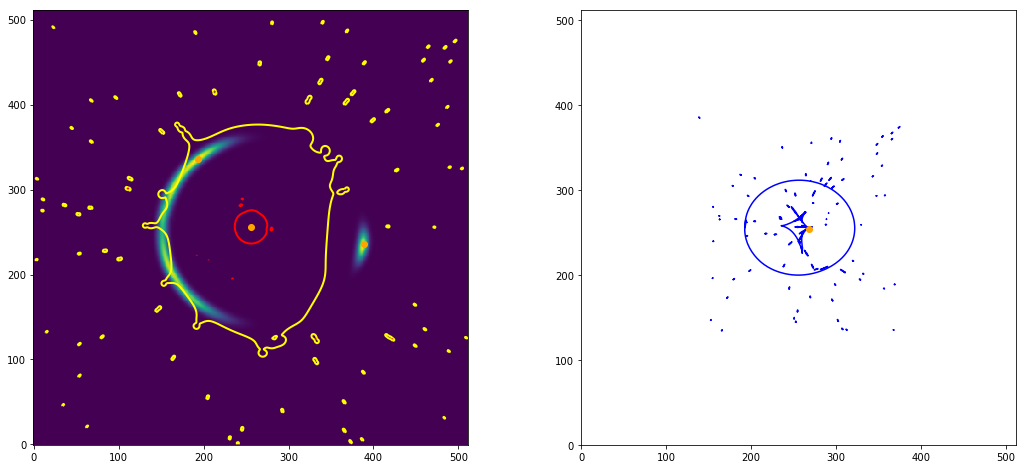

In [18]:
'''
Find the images of a source at (ys1,ys2) by mapping triangles on the lens plane into
triangles in the source plane. Then search for the triangles which contain the source. 
The image position is then computed by weighing with the distance from the vertices of the 
triangle on the lens plane
'''
def find_images(xk,yk,y1s,y2s,alpha1,alpha2):
    
    # ray tracing from the lens to the source plane
    xray=(xk-alpha1) # y1 coordinates on the source plane
    yray=np.transpose(yk-np.transpose(alpha2)) # y2 coordinates on the source plane

    xray=np.array(xray)/2.0/np.amax(xk)*xk.size+xk.size/2.0
    yray=np.array(yray)/2.0/np.amax(xk)*xk.size+xk.size/2.0
    
    # shift the maps by one pixel
    xray1=np.roll(xray,1,axis=1)
    xray2=np.roll(xray1,1,axis=0)
    xray3=np.roll(xray2,-1,axis=1)
    yray1=np.roll(yray,1,axis=1)
    yray2=np.roll(yray1,1,axis=0)
    yray3=np.roll(yray2,-1,axis=1)
    
    # for each pixel on the lens plane, build two triangle. By means of ray-tracing these are mapped onto the 
    # source plane into other two triangles. Compute the distances of the vertices of the triangles on the 
    # source plane from the source and check using cross-products if the source is inside one of the two triangles
    x1=y1s-xray
    y1=y2s-yray
    
    x2=y1s-xray1
    y2=y2s-yray1
    
    x3=y1s-xray2
    y3=y2s-yray2
    
    x4=y1s-xray3
    y4=y2s-yray3   
    
    prod12=x1*y2-x2*y1
    prod23=x2*y3-x3*y2
    prod31=x3*y1-x1*y3
    prod13=-prod31
    prod34=x3*y4-x4*y3
    prod41=x4*y1-x1*y4
    
    image=np.zeros(xray.shape)
    image[((np.sign(prod12) == np.sign(prod23)) & (np.sign(prod23) == np.sign(prod31)))]=1
    image[((np.sign(prod13) == np.sign(prod34)) & (np.sign(prod34) == np.sign(prod41)))]=2
    
    # if the source is inside a triangle, the images are saved on a map 
    #images = np.argwhere(image>0)
    #xi_=images[:,1]
    #yi_=images[:,0]
    
    #xi=xi_[(xi_>0) & (yi_>0)]
    #yi=yi_[(xi_>0) & (yi_>0)]

    # first kind of images (first triangle)
    images1=np.argwhere(image==1)
    xi_images_=images1[:,1]
    yi_images_=images1[:,0]
    xi_images=xi_images_[(xi_images_>0) & (yi_images_>0)]
    yi_images=yi_images_[(xi_images_>0) & (yi_images_>0)]
    
    # compute the weights
    w=np.array([1./np.sqrt(x1[xi_images,yi_images]**2+y1[xi_images,yi_images]**2),
       1./np.sqrt(x2[xi_images,yi_images]**2+y2[xi_images,yi_images]**2),
       1./np.sqrt(x3[xi_images,yi_images]**2+y3[xi_images,yi_images]**2)])
    xif1,yif1=refineImagePositions(xi_images,yi_images,w,1)
    
    # second kind of images
    images1=np.argwhere(image==2)
    xi_images_=images1[:,1]
    yi_images_=images1[:,0]
    xi_images=xi_images_[(xi_images_>0) & (yi_images_>0)]
    yi_images=yi_images_[(xi_images_>0) & (yi_images_>0)]
    
    # compute the weights
    w=np.array([1./np.sqrt(x1[xi_images,yi_images]**2+y1[xi_images,yi_images]**2),
       1./np.sqrt(x3[xi_images,yi_images]**2+y3[xi_images,yi_images]**2),
       1./np.sqrt(x4[xi_images,yi_images]**2+y4[xi_images,yi_images]**2)])
    xif2,yif2=refineImagePositions(xi_images,yi_images,w,1)        
    
    xi=np.concatenate([xif1,xif2])
    yi=np.concatenate([yif1,yif2])
    
    return(xi,yi)

def refineImagePositions(x,y,w,typ):
    if (typ==1):
        xp=np.array([x,x+1,x+1])
        yp=np.array([y,y,y+1])
    else:
        xp=np.array([x,x+1,x])
        yp=np.array([y,y+1,y+1])
    xi=np.zeros(x.size)
    yi=np.zeros(y.size)
    for i in range(x.size):
        xi[i]=(xp[:,i]/w[:,i]).sum()/(1./w[:,i]).sum()
        yi[i]=(yp[:,i]/w[:,i]).sum()/(1./w[:,i]).sum()
    return(xi,yi)


fig,ax=plt.subplots(1,2,figsize=(18,8))

ax[0].imshow(lambdar,origin='low',alpha=0)
ax[1].imshow(lambdar,origin='low',alpha=0)


# caustics!
cs=ax[0].contour((lambdat*lambdar),levels=[0.0],alpha=0)
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

from scipy.ndimage import map_coordinates

if (sizevs.size > 0):
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
            xx1,xx2=vs[i]
            x1.append(float(xx1))
            x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
        a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
        a2=map_coordinates(alpha2, [[x2],[x1]],order=1)
        
        # now we can make the mapping using the lens equation:
        y1=x1-a1[0]/(float(xmax-xmin)/npix)
        y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
        ax[1].plot(y1,y2,'-',color='blue')
        
ax[1].set_xlim([0,npix])
ax[1].set_ylim([0,npix])

ys1=268.0
ys2=254.0

ys1_=(ys1-npix/2.)*2.0*np.max(xk)/npix
ys2_=(ys2-npix/2.)*2.0*np.max(xk)/npix

xi,yi=find_images(xk,yk,ys1,ys2,alpha1,alpha2)
x1,x2,y1,y2=ray_trace(xk,yk,alpha1,alpha2)
image=lens_source_with_prof(y1,y2,ys1_,ys2_)
ax[0].imshow(image,origin='low')
ax[0].plot(xi,yi,'o',color='orange')
cst=ax[0].contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
csr=ax[0].contour(lambdar,levels=[0.0],colors='red',linewidths=2)
#ax[0].plot((xs1+np.max(xk))/2.0/np.max(xk)*xk.size,(xs2+np.max(xk))/2.0/np.max(xk)*xk.size,'o',color='orange')
ax[1].plot(ys1,ys2,'o',color='orange')
print np.min(xk),np.max(xk)

# Source de-lensing

If the lens model (namely the deflection angles) is known, it can be used to reconstruct the image of the source. The following example implements this reconstruction.


0.998250109101


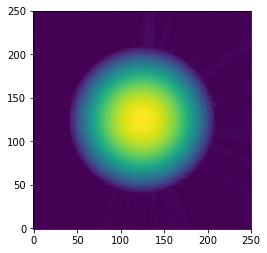

In [60]:
def delensSource(image,xk,yk,alpha1,alpha2,nspix,delta):
    from scipy.interpolate import griddata
    
    # ray tracing from the lens to the source plane
    xray=(xk-alpha1) # y1 coordinates on the source plane
    yray=np.transpose(yk-np.transpose(alpha2)) # y2 coordinates on the source plane
    
    thresh=1e-7
    
    # from whatever units to pixels
    xray=np.array(xray)/2.0/np.amax(xk)*xk.size+xk.size/2.0
    yray=np.array(yray)/2.0/np.amax(xk)*xk.size+xk.size/2.0
    
    xsmin,xsmax=np.min(xray[image>thresh]),np.max(xray[image>thresh])
    ysmin,ysmax=np.min(yray[image>thresh]),np.max(yray[image>thresh])
    
    xlim0=np.min([xsmin,ysmin])
    xlim1=np.max([xsmax,ysmax])
    dx=(xlim1-xlim0+2.0*delta)/(nspix-1)
    
    centerx=0.5*(xsmin+xsmax)
    centery=0.5*(ysmin+ysmax)
    
    y1=np.linspace(centerx-dx*(nspix-1)/2.0,centerx+dx*(nspix-1)/2.0,nspix)
    y2=np.linspace(centery-dx*(nspix-1)/2.0,centery+dx*(nspix-1)/2.0,nspix)
    gx,gy=np.meshgrid(y1,y2)
    
    #print 'the source is confined in the region',xsmin,xsmax,ysmin,ysmax
    
    xi=(xray[image>thresh]).reshape(xray[image>thresh].size)
    yi=(yray[image>thresh]).reshape(yray[image>thresh].size)
    flux=(image[image>thresh]).reshape(image[image>thresh].size)
    
    source_image= griddata((xi,yi), flux, (gx, gy), method='nearest')
    return(source_image)
    
source_ima=delensSource(image,xk,yk,alpha1,alpha2,250,1)
print source_ima.max()
plt.imshow(source_ima,origin='low',vmax=1.0,norm=LogNorm())

# Magnification on the source plane

Finally, the code below employs the same method outlined in the previous example to reconstruct the magnification pattern of the source plane. This is done as follows:

* we define a grid on the source plane. Each point on the grid is treated as a source.
* we find the images of each point on the source plane
* we assign to the point on the source plane a magnification which is the sum of the magnifications of all its images

In [20]:
xray=(xk-alpha1) # y1 coordinates on the source plane
yray=np.transpose(yk-np.transpose(alpha2)) # y2 coordinates on the source plane

yr1=xray.reshape(xray.size)
yr2=yray.reshape(yray.size)


(0, 512)

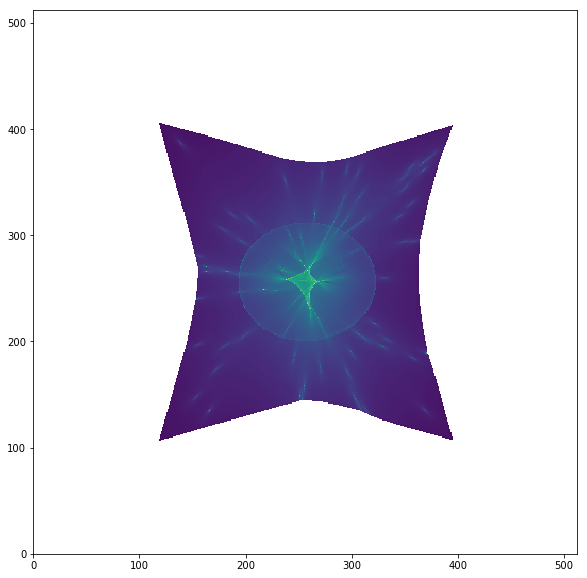

In [21]:
# the following code implements the algorithm described in Schneider, Ehlers & Falco 1992, page 300 -- 302
# to compute the magnification on the source plane

def mupds_map(xk,yk,alpha1,alpha2,lambdat,lambdar):
    deta=lambdar*lambdat
    mus=np.array(deta)*0.0

    deray=1.0#xk[1]-xk[0]
    xcheck=np.zeros(4)
    ycheck=np.zeros(4)
    
    
    xray=(xk-alpha1) # y1 coordinates on the source plane
    yray=np.transpose(yk-np.transpose(alpha2)) # y2 coordinates on the source plane

    xray=np.array(xray)/2.0/np.amax(xk)*xk.size+xk.size/2.0
    yray=np.array(yray)/2.0/np.amax(xk)*xk.size+xk.size/2.0
    xray=xray.reshape([xk.size,yk.size],order='F')
    yray=yray.reshape([xk.size,yk.size],order='F')

    for i in range(xk.size-1):
        for j in range(yk.size-1):
            xcheck[0]=xray[i,j]
            xcheck[1]=xray[i+1,j]
            xcheck[2]=xray[i+1,j+1]
            xcheck[3]=xray[i,j+1]
            ycheck[0]=yray[i,j]
            ycheck[1]=yray[i+1,j]
            ycheck[2]=yray[i+1,j+1]
            ycheck[3]=yray[i,j+1]
            
            xmax=np.max(xcheck)
            xmin=np.min(xcheck)
            ymax=np.max(ycheck)
            ymin=np.min(ycheck)
            
            imax=np.int(np.int(xmax/deray)+1)
            imin=np.int(np.int(xmin/deray))
            jmax=np.int(np.int(ymax/deray)+1)
            jmin=np.int(np.int(ymin/deray))
            if (imin <0):
                imin=0
            if (jmin <0):
                jmin=0
            if (imax>xk.size):
                imax=xk.size
            if (jmax>yk.size):
                jmax=yk.size
                
            for ii in range(imin,imax):
                for jj in range(jmin,jmax):
                    x1=ii*deray-xray[i,j]
                    y1=jj*deray-yray[i,j]
                    x2=ii*deray-xray[i+1,j]
                    y2=jj*deray-yray[i+1,j]
                    x3=ii*deray-xray[i+1,j+1]
                    y3=jj*deray-yray[i+1,j+1]
                    x4=ii*deray-xray[i,j+1]
                    y4=jj*deray-yray[i,j+1]
                    prod12=x1*y2-x2*y1
                    prod23=x2*y3-x3*y2
                    prod31=x3*y1-x1*y3
                    prod13=-prod31
                    prod34=x3*y4-x4*y3
                    prod41=x4*y1-x1*y4
                    if (np.sign(prod12) == np.sign(prod23) and np.sign(prod23) == np.sign(prod31)):
                        '''the first triangle contains the source!'''
                        dist2sum=(1./(x1**2+y1**2))+(1./(x2**2+y2**2))+(1./(x3**2+y3**2))
                        det1=np.abs(deta[i,j])
                        det2=np.abs(deta[i+1,j])
                        det3=np.abs(deta[i+1,j+1])
                        det_interp=((det1/(x1**2+y1**2))+(det2/(x2**2+y2**2))+(det3/(x3**2+y3**2)))/dist2sum
                        mu_interp=1./det_interp
                        mus[jj,ii]=mus[jj,ii]+mu_interp
                    elif (np.sign(prod13) == np.sign(prod34) and np.sign(prod34) == np.sign(prod41)):
                        '''the second triangle contains the source!'''
                        dist2sum=(1./(x1**2+y1**2))+(1./(x3**2+y3**2))+(1./(x4**2+y4**2))
                        det1=np.abs(deta[i,j])
                        det2=np.abs(deta[i+1,j+1])
                        det3=np.abs(deta[i,j+1])
                        det_interp=((det1/(x1**2+y1**2))+(det2/(x3**2+y3**2))+(det3/(x4**2+y4**2)))/dist2sum
                        mu_interp=1./det_interp
                        mus[jj,ii]=mus[jj,ii]+mu_interp                        
    return(mus)




xkk=[]
ykk=[]
for i in range(xk.size):
    for j in range(yk.size):
        xkk.append(xk[i]-alpha1[j,i])
        ykk.append(yk[j]-alpha2[j,i])
        
fig,ax=plt.subplots(1,1,figsize=(10,10))
mus=mupds_map(xk,yk,alpha1,alpha2,lambdat,lambdar)
xkk=np.array(xkk)/2.0/np.amax(xk)*xk.size
ykk=np.array(ykk)/2.0/np.amax(xk)*xk.size
#ax.plot(xkk,ykk,',')
ax.imshow(mus,origin='low',norm=LogNorm())

overplotcaustics=False
if (overplotcaustics):

    icau=0
    if (sizevs.size > 0):
        for j in range(len(p)):
            # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
            vs = contour.get_paths()[j].vertices 
            sizevs[j]=len(vs)
            x1=[]
            x2=[]
            for i in range(len(vs)):
                xx1,xx2=vs[i]
                x1.append(float(xx1))
                x2.append(float(xx2))
        # these are the points we want to map back on the source plane. 
        # To do that we need to evaluate the deflection angle at their positions
        # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
            a1=map_coordinates(alpha1, [[x2],[x1]],order=1)
            a2=map_coordinates(alpha2, [[x2],[x1]],order=1)
        
        # now we can make the mapping using the lens equation:
            y1=x1-a1[0]/(float(xmax-xmin)/npix)
            y2=x2-a2[0]/(float(xmax-xmin)/npix)
        
        # plot the results!
            if (icau==0):
                ax.plot(y1,y2,'-',color='yellow',lw=2)
                icau=1
            else:
                ax.plot(y1,y2,'-',color='white',lw=2)
                
ax.set_xlim([0,xk.size])
ax.set_ylim([0,yk.size])

Note that when we map the whole lens plane onto the source plane, the area entering the FOV is actually smaller than that subtended by the lens plane. This is due to magnification! The main implication of this result is that when we look at the sky through a gravitational lens, whe are observing a smaller volume of the Universe compared to what we would see in absence of lensing.